<a href="https://colab.research.google.com/github/ryanleeallred/DS-Unit-4-Sprint-3-Deep-Learning/blob/main/module4-time-series/LS_DS_434_Time_Series_Forecasting_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting using LSTMs 

## Objective 

- Students will understand how to prepare time series data for model ingestion (sliding train-test split) 
- Students will understand how to use a LSTM model for time series forecasting applications
- Students will understand the importance of seasonality and trends in time series applications.


### Applications of Time Series Forecasting 

![](https://miro.medium.com/max/2668/1*s7P8zInIavYbevpZg_iPaA.jpeg)


----
### Load Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Activation, Dropout
import time #helper libraries
from tensorflow.keras import regularizers

----
### Load Data

In [1]:
def load_transform_data(weather_filepath, energy_filepath):
    """
    Load energy and weather data sets for energy consumption over a 4 year period for a single household in Austin, Texas. 
    Perform transformations in order to get data into a format that we can more easily use for LSTM modeling.
    
    Notes
    -----
    Links to source of data:
    https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries?select=weather_2016_2020_daily.csv
    
    Parameters 
    ------
    None
    
    Returns
    -------
    df: pandas dataframe
        Contains both the energy and weather feature sets 
    """

----
### Explore data with some plots

----
### Feature Selection

In [1]:
# Correlation Heat Map

----
### Scale Data

In [ ]:
def scale_data(df):
    """
    Scale time series features, save the scaler function for each feature in a look up dict for inverse scaling post model training. 
    
    Parameters
    ----------
    df: pandas dataframe
    
    Returns
    -------
    df: pandas datafarme 
        Contains scaled features
        
    scaler_dict: dict 
        look up for feature scaler objects 
        key: column name
        value: column scaler 
    """
    
    # use to save the column scaler functions
    scaler_dict = {} 
    
    # use to save the scaled column data
    scaled_data = {} 
    
    for col in df.columns:
        
        # instantiate the scaler class 
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # reshape to avoid shape errors
        feat = df[col].values.reshape(-1, 1)
        
        # scale data
        col_scaled = scaler.fit_transform(feat)
        
        # save scaled column data to column key
        scaled_data[col] = col_scaled.flatten()
        
        # save scaler function to column key 
        scaler_dict[col] = scaler
        
    # move scaled data from dict to dataframe
    df_scaled = pd.DataFrame.from_dict(scaled_data)
    
    return df_scaled, scaler_dict

In [2]:
# plot non-scaled data


In [3]:
# scale data 


In [4]:
# plot scaled data



----
### Create Samples

![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/11/Sliding-Window-Approach-to-Modeling-Time-Series.png)

In [ ]:
def create_dataset(data, look_back=1, look_ahead=1):
    """
    Takes a 2D array of sequential data and creates (X) input and (Y) output sequences for timeseries forecasting.
    
    Paramters
    ---------
    data: 2D numpy array
        contains sequential data with n rows and m columns
        
        If you provide more than a single input feature, make sure that the feature that is also used for the output
        is positioned in the 0 (zero) index column of the the array. Code below assumes this to be the case! 
        
        Example
        -------
        For the example data below, kWh column will be used as the output feature (i.e. what the model will be predicting).
        
                    kWh     Temp_avg
            0	0.335705	0.785256
            1	0.526399	0.951923
            2	0.697993	0.961538
            3	0.467702	0.891026
            4	0.399143	0.842949      
        
    look_back: int or float
        length of input sequence 
        
        I.E if look_behind = 1, then the input is a single value with index [t] (the present timestep)
            if look_behind = 2, then the input is a sequence of vlaues with indices [t - 1, t]
            if look_behind = n, then the input is a sequence of values with indices [t - n, t - (n - 1), ... , t - 1, t]
            
    look_ahead: int or float
        number of steps into the future that we want to forecast
        
        I.E. if look_ahead = 1, then we want to forecast the value 1 timestep from now,  t + 1
             if look_ahead = 2, then we want to forecast the value 2 timesteps from now, t + 2
             if look_ahead = b, then we want to forecast the value n timesteps from now, t + n
    """
    # use to store new sequence samples 
    X_data, Y_data = [], []
    
    # number of original samples in dataset
    n_samples = len(data)
    
    # avoid an index error in the for loop by capping the max index value 
    # since we are using look_back & look_ahead number of samples for input and output sequences, respectively
    truncate = look_back + look_ahead 
    
    # number of new samples to create
    # we must subtract truncate from the number of new samples because the size of the look_back & look_ahead windows 
    n_new_samples = n_samples - (truncate + 1)
    
    # if user provided data with more than a single input feature
    # then index for the feature in the 0 index and use that as the output feature
    if data.shape[1] > 1:
        y_data = data[:, 0]
        
    # if user provided a single feature dataset, leave data set as is 
    else:
        y_data = data

    # Now we drop the target (first column) from the data array
    data = data[:, 1:]
        
    # LOGIC FOR CREATING X AND Y 
    # we are going to create n_new_samples number of samples for our model 
    for i in range(n_new_samples):
        
        # create input sequence sample 
        x = data[i : i+look_back]
        
        # create output sequence sample 
        y = y_data[i+look_back : i + look_back + look_ahead ]
        y = y[-1] # y is actually a sequnce, so we need to take the last value as our output (i.e. we are predicting a single value, not multiple)
        
        # append new samples to lists
        X_data.append(x)
        Y_data.append(y)
        
    return np.array(X_data), np.array(Y_data)

# create_dataset(df, look_back=7, look_ahead=1)

![](https://i.stack.imgur.com/fXZ6k.png )

Let's create a small and simple dummy data set as input for `create_data` in order to see how the input and output data are structured. 

In [5]:
# create dummy array to test how function works
# note: the values here are completely arbitrary
# but using small, sequential integers helps us understanding the structuring of the sequences 


In [ ]:
def create_train_test_split(df, look_back = 1, look_ahead = 1, train_size = 0.60):
    """
    Creates a train test split for sequential data used for time series forecasting. 
    """
    
    # calculate the number of training samples 
    n_samples = df.shape[0]
    train_size = int(n_samples * train_size)

    # samples between the zero and train_size indices are training samples 
    train = df.iloc[:train_size].values
    
    # samples between the train_size and the nth index are test samples 
    test = df.iloc[train_size:].values

    # create input and output splits 
    X_train, Y_train = create_dataset(train, look_back=look_back, look_ahead=look_ahead)
    X_test, Y_test = create_dataset(test, look_back=look_back, look_ahead=look_ahead)
    
    return X_train, Y_train, X_test, Y_test

In [7]:
# split data into X and Y train/test sets 


----
### Create and train model

---
### Visualize model results

In [ ]:
def plot_model_loss_metrics(history):
    """
    Use the model history callback to plot the train and test losses vs epochs as well as metrics vs. epochs 
    """
    
    # plot training and test loss scores 
    test_loss = history.history["val_loss"]
    train_loss = history.history["loss"]
    
    test_mse = history.history["val_mean_squared_error"]
    train_mse = history.history["mean_squared_error"]
    
    test_mae = history.history["val_mean_absolute_error"]
    train_mae = history.history["mean_absolute_error"]
    
    n_epochs = len(test_loss) + 1
    epoches = np.arange(1,  n_epochs)
    y_ticks = np.arange(0, 1, 11)

    plt.figure(figsize=(20,5))
    plt.title("Loss vs. Number of Epochs")
    plt.plot(epoches, test_loss, label = "Test Loss")
    plt.plot(epoches, train_loss, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 
    
    
    plt.figure(figsize=(20,5))
    plt.title("mean_squared_error vs. Number of Epochs")
    plt.plot(epoches, test_mse, label = "Test Loss")
    plt.plot(epoches, train_mse, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 
    
    
    plt.figure(figsize=(20,5))
    plt.title("mean_absolute_error vs. Number of Epochs")
    plt.plot(epoches, test_mae, label = "Test Loss")
    plt.plot(epoches, train_mae, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 

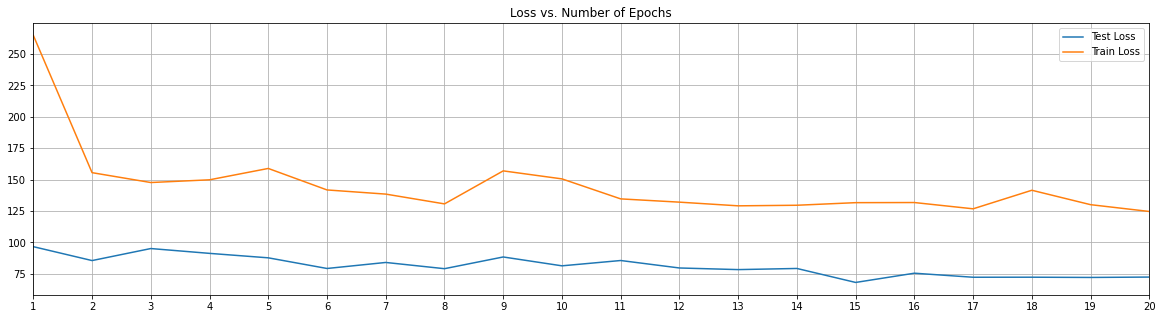

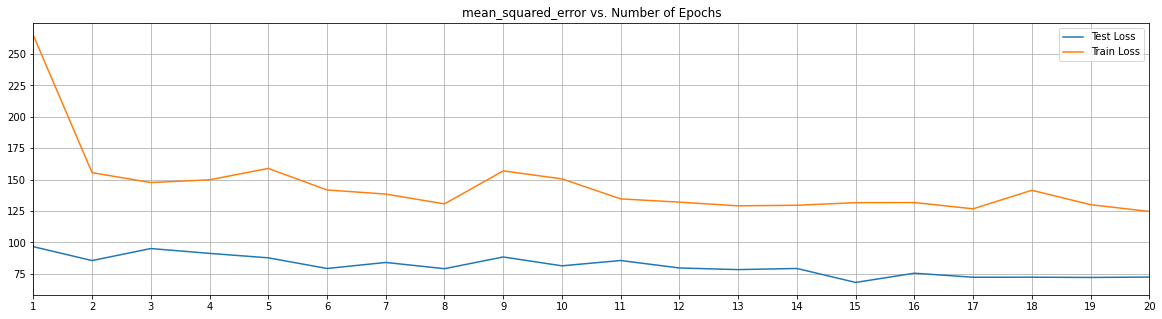

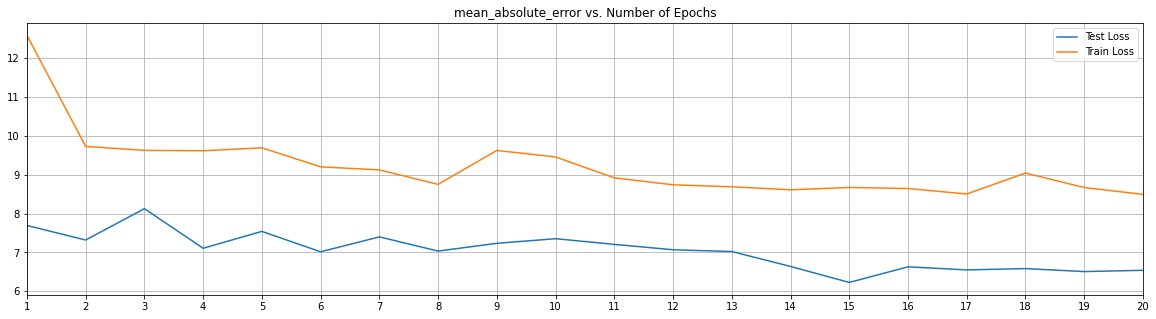

In [ ]:
# plot model scores
plot_model_loss_metrics(history)

In [ ]:
def predict(X_train, X_test):
    # make predictions on train and test inputs 
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    return y_train_predict, y_test_predict

In [ ]:
# get predictions 
y_train_predict, y_test_predict = predict(X_train, X_test)

In [ ]:
# Y_test and Y_train can be passed through this function only once
# predictions can be passed in here multiple times 
def inverse_scaling(data, scaler_dict, output_feat_name):
    """
    Now that we have trained our model on scaled data (and made predictions on the scaled test data)
    we need to invert the scaling so we have have the data in it's original formate for interpretability. 
    """
    return scaler_dict[output_feat_name].inverse_transform(data)

In [ ]:
# reshape Y_train and Y_test so number of rows appers first, i.e. (rows,cols)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# y_train

In [ ]:
# undo our normalization to plot our predictions in actual kwh
y_train_predict = inverse_scaling(y_train_predict, scalers, 'kwh')
y_test_predict = inverse_scaling(y_test_predict, scalers, 'kwh')

In [ ]:
# perform inverse scaling of the data
y_train = inverse_scaling(y_train, scalers, 'kwh')
y_test = inverse_scaling(y_test, scalers, 'kwh')

----
### Plot Model Predictions

In [ ]:
def plot_predictions(Y_train, y_train_predict, Y_test, y_test_predict):
    
    
    plt.figure(figsize=(20,5))
    plt.title("Training Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_train_predict, label = "Predict", c="r")
    plt.plot(Y_train, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();
    
    plt.figure(figsize=(20,5))
    plt.title("Test Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_test_predict, label = "Predict", c="r")
    plt.plot(Y_test, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();

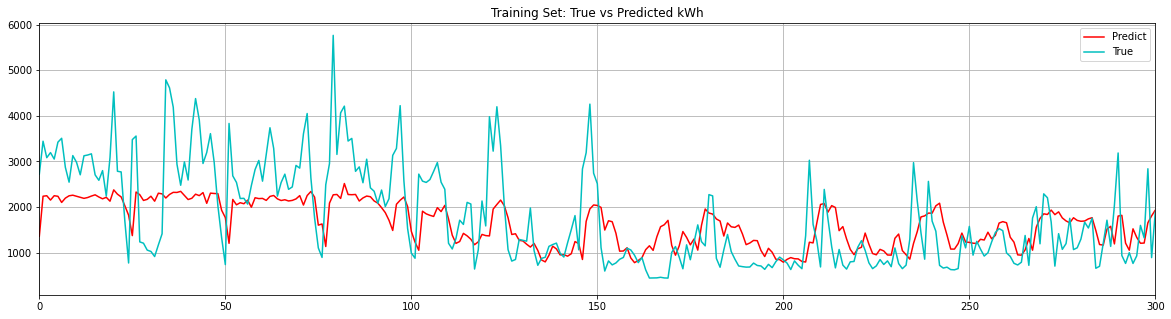

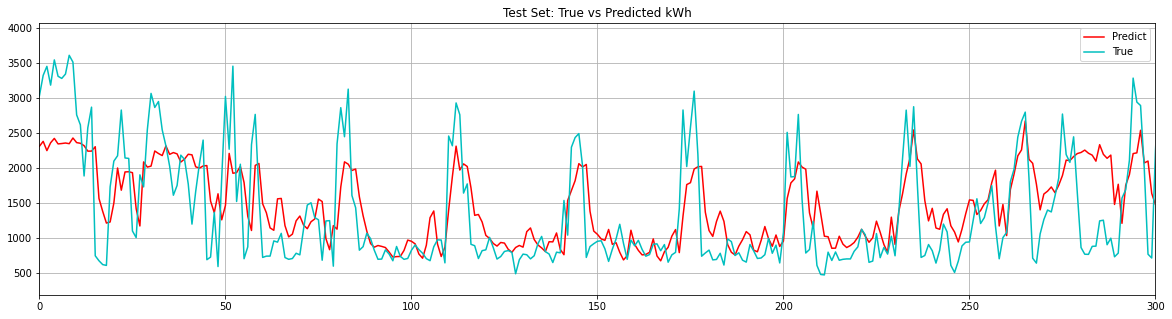

In [ ]:
# plot model predictions 

plot_predictions(y_train, y_train_predict, y_test, y_test_predict)

-----
### Compare Model against a Baseline 

One commen baseline to use is to simply shift the kWh values up by `look_ahead` amount and compare that to the true values that occur an a date. In order words, assume that the kWh consumption tomorrow will be the same as the energy consumption to today. So then we can ask the question "can the model perform better than simply assuming that tomorrow will look like today?"

Of course since `look_ahead` can be any value (not just 1) then the navie guess becomes "assume that the kWh consumption X number of days from now be the same as today."

In [ ]:
# use root mean squared error as metric for comparison 
train_score = math.sqrt(mean_squared_error(Y_train, y_train_predict))
print('Train Score: %.4f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(Y_test, y_test_predict))
print('Test Score: %.4f RMSE' % (test_score))

naive_score = math.sqrt(mean_squared_error(...?,...?))
print('Naive baseline Score: %.4f RMSE' % (test_score))

SyntaxError: ignored